# <span style="color:orange"> Laboratorio di Simulazione Numerica </span>
## <span style="color:orange"> Esercitazione 8 </span>

### Paolo Panatti (12606A)

In questa esercitazione vogliamo stimare il ground state di una particella quantistica in uno spazio monodimensionale soggetta al potenziale esterno $V(x) = x^4 - \frac{5}{2}x^2$ tramite una simulazione Monte Carlo che sfrutta il principio variazionale.

In Meccanica Quantistica, il **principio variazionale di Ritz** afferma che il valore di aspettazione dell'Hamiltoniana su un qualsiasi stato di prova è limitato inferiormente dall'energia $E_0$ dello stato fondamentale:
$$\langle {\hat H} \rangle_T = \frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}{\int dx |\Psi_T(x)|^2} \ge E_0 = \frac{\langle \Psi_0 | {\hat H} | \Psi_0 \rangle}{\langle \Psi_0 | \Psi_0 \rangle}$$

Possiamo dunque approssimare lo stato fondamentale ottimizzando i parametri di una particolare funzione d'onda di prova. Nel nostro caso una buona funzione di prova è la seguente:
$$\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+e^{-\frac{(x+\mu)^2}{2\sigma^2}}$$
ossia la somma di due gaussiane di larghezza $\sigma$ centrate in $\pm\mu$. 

$\mu$ e $\sigma$ sono i due parametri variazionali che dobbiamo ottimizzare in modo da rendere minimo il valor medio dell'Hamiltoniana.

### <font color="blue"> Esercizio 08.1

#### Obiettivo:
Scrivere un codice Variational Monte Carlo (VMC) per calcolare il valore di aspettazione dell'Hamiltoniana
$$\langle {\hat H} \rangle_T = \frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}{\int dx |\Psi_T(x)|^2} = \int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}$$
implementando l'algoritmo di Metropolis, con probabilità di transizione $T(x_{new}|x_{old})$ uniforme, per campionare il modulo quadro della nostra funzione d'onda di prova $|\Psi_T^{\sigma,\mu}(x)|^2$ e utilizzando il metodo data blocking.

Per campionare punti distribuiti secondo la distribuzione di probabilità $p(x) = \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2}$, che compare all'interno dell'integrale, sfruttiamo l'algoritmo di Metropolis: partendo dalla posizione iniziale $x=0$, ad ogni step viene proposta una nuova posizione $y=x+r$ generando un numero casuale $r$ distribuito uniformemente nell'intervallo $\left[-\delta,\delta\right]$. Questa mossa viene accettata con probabilità $A(y|x)=\min\left[1,\frac{|\Psi_T(y)|^2}{|\Psi_T(x)|^2}\right]$. Il parametro $\delta$ viene impostato in base ai valori dei due parametri variazionali $\mu$ e $\sigma$ dalla funzione ```set_delta()``` in modo da avere un'accettanza del $50\%$ circa, buon equilibrio tra efficienza computazionale ed esplorazione dello spazio delle configurazioni.

Per valutare la funzione integranda $\frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}$ ho dovuto calcolare analiticamente la derivata seconda della funzione d'onda di prova. Ho assunto, inoltre, un sistema di unità in cui $\hbar = m = 1$.

Come al solito, al fine di stimare correttamente le incertezze statistiche, ho utilizzato il metodo data blocking con $100$ blocchi da $10^4$ passi ciascuno.

Ecco i grafici che mostrano il valor medio dell'Hamiltoniana con la sua incertezza in funzione del numero di blocchi, l'accettanza dell'algoritmo di Metropolis in funzione del numero di blocchi e la distribuzione di probabilità campionata nel caso $\mu=0$ e $\sigma=1$.

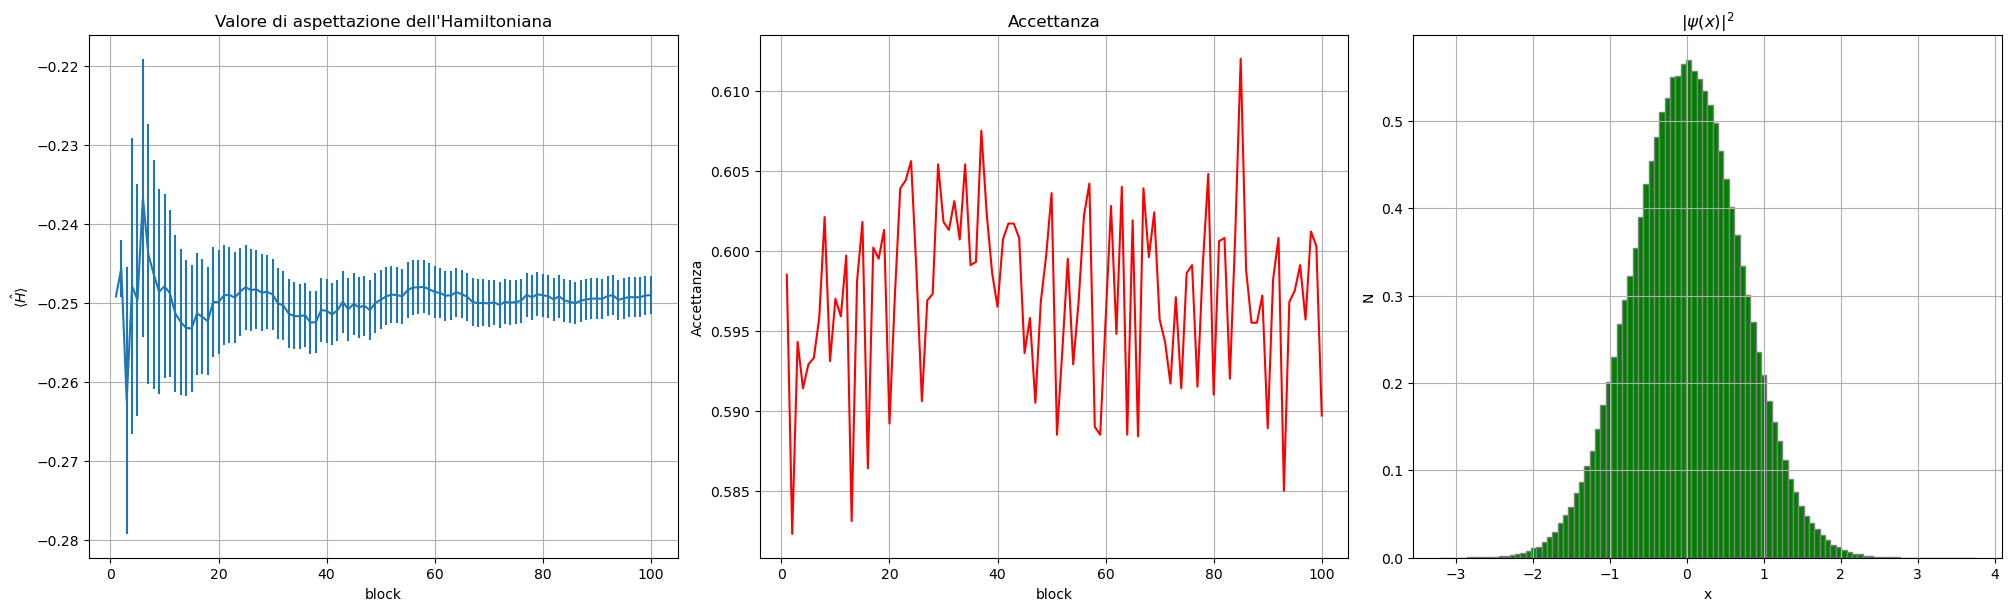

In [27]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

blocks = np.arange(100)+1
acceptance = np.loadtxt("Es1/acceptance_prova.dat", usecols=1, unpack='true')
energy, err = np.loadtxt("Es1/energy_prova.dat", usecols=(2,3), unpack='true')
x = np.loadtxt("Es1/configurations_prova.dat", usecols=0, unpack='true')

fig, axes = plt.subplots(1, 3, figsize=(20,6), constrained_layout=True)

axes[0].errorbar(blocks,energy,yerr=err)
axes[0].set_xlabel('block')
axes[0].set_ylabel(r'$\langle {\hat H} \rangle$')
axes[0].set_title("Valore di aspettazione dell'Hamiltoniana")
axes[0].grid(True)

axes[1].plot(blocks,acceptance,color='red')
axes[1].set_xlabel('block')
axes[1].set_ylabel('Accettanza')
axes[1].set_title('Accettanza')
axes[1].grid(True)

axes[2].hist(x,bins=100,density=True,color='green',edgecolor='grey')
axes[2].set_xlabel('x')
axes[2].set_ylabel('N')
axes[2].set_title(r'$|\psi(x)|^2$')
axes[2].grid(True)

### <font color="blue"> Esercizio 08.2

#### Obiettivo:
Ottimizzare i parametri $\mu$ e $\sigma$ tramite un algoritmo di Simulated Annealing (SA).

#### Simulated Annealing
Si tratta di un algoritmo di ottimizzazione stocastica ispirato al modo in cui i liquidi cristallizzano quando vengono raffreddati lentamente. La struttura cristallina ordinata che si forma a basse temperature corrisponde infatti allo stato con energia minima. L'idea, perciò, è quella di interpretare la funzione costo $L(\mathbf{x})$ da minimizzare come l'energia di un sistema fisico fittizio e di associare ad ogni configurazione un peso di Boltzmann $p(\mathbf{x})=\exp\left[-\beta L(\mathbf{x})\right]/Z$: nel limite di bassa temperatura $\beta\to\infty$, tale distribuzione si concentrerà attorno ai minimi di $L(\mathbf{x})$. Si scelgono, dunque, diversi valori di $\beta$ via via crescenti e, per ciascuno di essi, si campiona il peso di Boltzmann tramite un algoritmo di Metropolis eseguendo un certo numero di step Monte Carlo e partendo ogni volta dalla configurazione finale del ciclo precedente. Così facendo, al termine della simulazione si otterranno valori dei parametri che approssimano quelli ottimali.

Nel nostro caso la funzione da minimizzare è $\langle {\hat H} \rangle_T$, che presenta $4$ minimi simmetrici. Per questo motivo, ho imposto dei vincoli sui parametri: $\mu > 0$ e $\sigma > 0.1$ (valori troppo piccoli di $\sigma$ possono causare problemi nel campionamento del modulo quadro della funzione d'onda).

Per la temperatura iniziale ho scelto un valore pari a $2.0$. Questa viene poi moltiplicata progressivamente per $0.99$ fino a raggiungere un valore finale di circa $0.01$. Per ciascuna di queste temperature vengono eseguiti $100$ passi Monte Carlo: vengono proposti casualmente nuovi valori dei parametri compatibili con i vincoli, accettando le mosse con probabilità $A = \min\left(1,e^{-\beta \Delta E}\right)$, dove $\Delta E$ è la differenza fra le energie delle due configurazioni nuova e vecchia. Queste vengono calcolate utilizzando il codice dell'esercizio precedente (questa volta con $100$ blocchi da $10^3$ passi), che è stato inserito all'interno della funzione ```compute_H()```. Per quanto riguarda lo spostamento dei parametri, estratto casualmente da una distribuzione uniforme, ho scelto un'ampiezza massima $\delta = 0.5 T$ proporzionale alla temperatura $T$ in modo da rendere più efficace la ricerca del minimo. I valori di partenza dei parametri sono $\mu=1$ e $\sigma=1$.

I seguenti grafici mostrano, in funzione di $\beta$, l'andamento di $\langle {\hat H} \rangle_T$ con il suo errore statistico e la traiettoria dell'algoritmo SA nello spazio dei parametri.

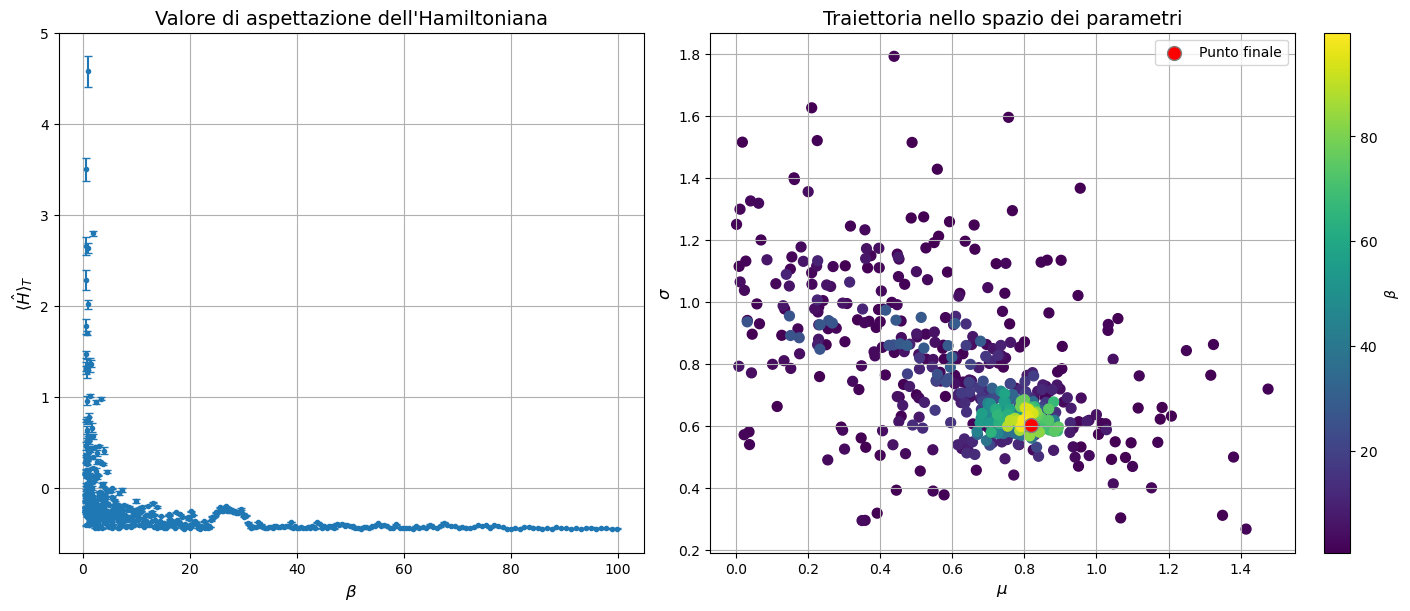

In [29]:
T, mu, sigma, H, err = np.loadtxt("Es2/parameters.dat", usecols=(0,1,2,3,4), unpack='true')
beta = 1./T

fig, axes = plt.subplots(1, 2, figsize=(14,6), constrained_layout=True)

axes[0].errorbar(beta,H,yerr=err,fmt='o',markersize=3,capsize=3)
axes[0].set_xlabel(r'$\beta$',fontsize=12)
axes[0].set_ylabel(r'$\langle {\hat H} \rangle_T$',fontsize=12)
axes[0].set_title("Valore di aspettazione dell'Hamiltoniana",fontsize=14)
axes[0].grid(True)

scatter = axes[1].scatter(mu,sigma,c=beta,cmap='viridis',s=50)
axes[1].scatter(mu[-1],sigma[-1],color='red',edgecolor='grey',s=100,label='Punto finale')
axes[1].set_xlabel(r'$\mu$',fontsize=12)
axes[1].set_ylabel(r'$\sigma$',fontsize=12)
axes[1].set_title('Traiettoria nello spazio dei parametri',fontsize=14)
cbar = fig.colorbar(scatter)
cbar.set_label(r'$\beta$')
axes[1].legend()
axes[1].grid(True)

Possiamo osservare che, ad alte temperature ($\beta$ piccolo), l'energia assume valori decisamente elevati e i parametri variano di parecchio. Ciò accade dal momento che tutte le configurazioni possono essere esplorate, comprese quelle meno favorevoli. Man mano che la temperatura diminuisce ($\beta$ aumenta), invece, l'energia converge verso un valore minimo stabile e i punti nello spazio dei parametri si concentrano in una regione sempre più ristretta.

I parametri ottimali risultano: $\mu = 0.817861$ e $\sigma = 0.605328$.

Infine, ho inserito i valori individuati all'interno del codice dell'esercizio $08.1$ per poter rappresentare valor medio e incertezza progressivi di $\langle {\hat H} \rangle_T$ per il miglior set di parametri in funzione del numero di blocchi. Ho rappresentato anche la distribuzione di probabilità campionata $|\Psi_T(x)|^2$ insieme alla curva analitica e alla soluzione numerica ricavabile trasformando l'equazione di Schrödinger in un'equazione matriciale.

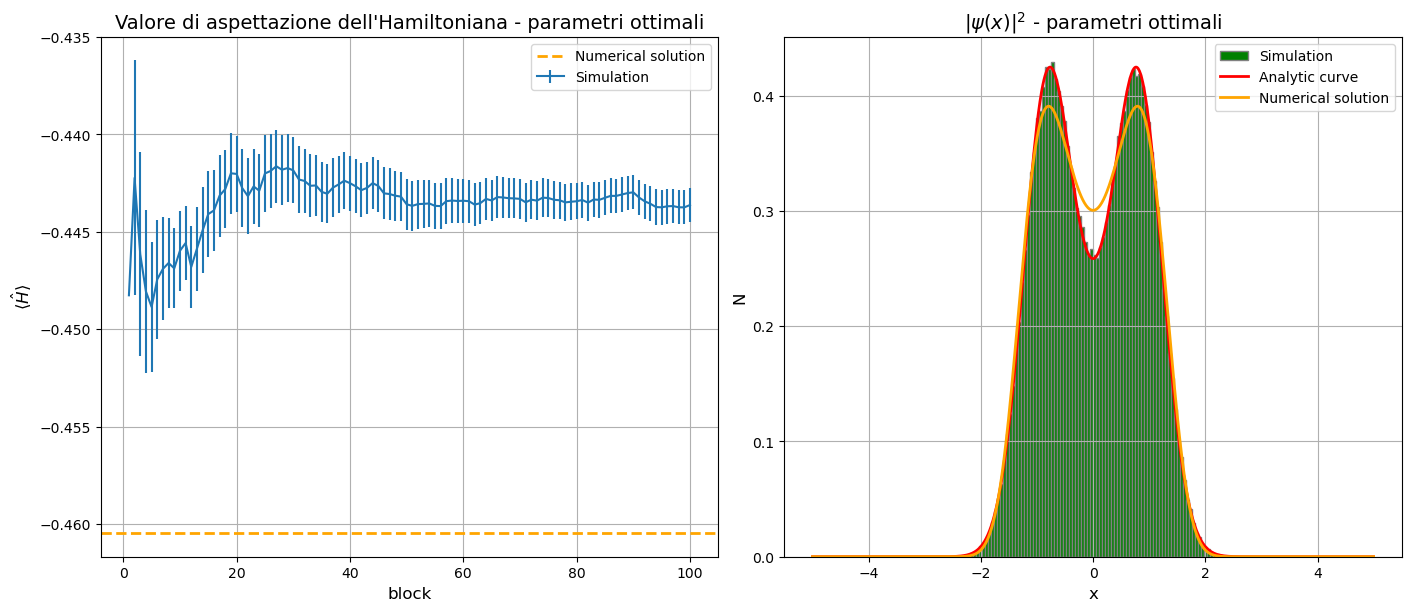

In [45]:
from scipy.integrate import quad

def psisquared(x,mu,sigma):
    return (np.exp(-(x-mu)**2/(2*sigma**2))+np.exp(-(x+mu)**2/(2*sigma**2)))**2

norm, _ = quad(lambda x: psisquared(x,mu[-1],sigma[-1]),-np.inf,np.inf)

def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

energy, err = np.loadtxt("Es1/energy.dat", usecols=(2,3), unpack='true')
confs = np.loadtxt("Es1/configurations.dat", usecols=0, unpack='true')

fig, axes = plt.subplots(1, 2, figsize=(14,6), constrained_layout=True)

axes[0].errorbar(blocks,energy,yerr=err,label='Simulation')
axes[0].axhline(E[0],color='orange',linestyle='--',linewidth=2,label='Numerical solution')
axes[0].set_xlabel('block',fontsize=12)
axes[0].set_ylabel(r'$\langle {\hat H} \rangle$',fontsize=12)
axes[0].set_title("Valore di aspettazione dell'Hamiltoniana - parametri ottimali",fontsize=14)
axes[0].legend()
axes[0].grid(True)

axes[1].hist(confs,bins=100,density=True,color='green',edgecolor='grey',label='Simulation')
axes[1].plot(x,psisquared(x,mu[-1],sigma[-1])/norm,color='red',linewidth=2,label='Analytic curve')
axes[1].plot(x,psi[0]**2,color='orange',linewidth=2,label='Numerical solution')
axes[1].set_xlabel('x',fontsize=12)
axes[1].set_ylabel('N',fontsize=12)
axes[1].set_title(r'$|\psi(x)|^2$ - parametri ottimali',fontsize=14)
axes[1].legend()
axes[1].grid(True)

L'energia del ground state risulta $-0.4436 \pm 0.0009$, leggermente superiore rispetto a quella calcolata numericamente, pari a $-0.46046587969271513$ (linea tratteggiata nel grafico). Allo stesso modo, le due funzioni d'onda sono molto simili ma non identiche. Capiamo quindi che il metodo variazionale, pur essendo approssimato, rappresenta un ottimo strumento per la stima dello stato fondamentale di un sistema quantistico.